## 0. Import all the libraries

In [143]:
import numpy as np
import numpy.linalg as la
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import string
import tqdm
import numba
import matplotlib.pyplot as plt
import scipy.spatial.distance as dist
import spacy
import sklearn
from sklearn.metrics.pairwise import cosine_similarity
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\satt-\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\satt-\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\satt-\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## 1. Print all the sentences

In [144]:
USE_TRAIN = True
with open('input.txt') as f:
    lines_test = [line.strip() for line in f]
with open('movies_text.txt') as f:
    lines_train = [line.strip() for line in f]

print(len(lines_test))
#lines_train = lines_train[:30]
#print(lines_movies[:10])

250


## 2. Preprocessing : remove punctuation, stopwords and lemmatize

In [145]:
stopwords_en = stopwords.words('english')
translation_table = str.maketrans('', '', string.punctuation)
lemmatizer = WordNetLemmatizer()
lemmas = set(wordnet.all_lemma_names())

words = dict()
test_words = dict()
sentences_test = list()

for line in lines_test:
    s1, s2 = line.split('\t')

    v1 = []
    v2 = []

    for s, v in [(s1, v1), (s2, v2)]:
        for w in s.split():
            w = w.lower().translate(translation_table)
            if w in stopwords_en:
                continue
            w = lemmatizer.lemmatize(w)
            if w not in lemmas:
                continue
            words.setdefault(w, len(words))
            test_words.setdefault(w, len(test_words))
            v.append(words[w])

    sentences_test.append((v1, v2))

sentences_train = list()
if USE_TRAIN:
    for s in lines_train:
        #s1, s2 = line.split('\t')
        
        v = []
        

        for w in s.split():
            w = w.lower().translate(translation_table)
            if w in stopwords_en:
                continue
            w = lemmatizer.lemmatize(w)
            if w not in lemmas:
                continue
            
            words.setdefault(w, len(words))
            v.append(words[w])

        sentences_train.append(v)
    


In [147]:
print(len(words.keys()))
print(len(test_words.keys()))


18669
687


## 3. Make synonyms graph

In [153]:
synonym_graph = np.zeros((len(words), len(words)))

def set_of_synonyms(word):
    synonyms = []
    for syn in wordnet.synsets(word):
        for l in syn.lemmas():
            syn_word = l.name()
            if syn_word in stopwords_en:
                continue
            syn_word = lemmatizer.lemmatize(syn_word)
            synonyms.append(syn_word)
    return set(synonyms)

for word, idx in words.items():
    for syn in set_of_synonyms(word):
        if syn not in words:
            continue
        syn_idx = words[syn]
        synonym_graph[idx][syn_idx] = 1
        synonym_graph[syn_idx][idx] = 1
if USE_TRAIN:
    synonym_graph = synonym_graph[:len(test_words), :len(test_words)]


In [149]:
print(set_of_synonyms(list(words.keys())[0]))
print(sum(synonym_graph[0]))


{'person', 'mortal', 'someone', 'soul', 'somebody', 'individual'}
6.0


## 4. Make sliding window graph

In [150]:
window_size = 3

window_graph_train = np.zeros((len(words), len(words)))

for ss in sentences_test:
    for s in ss:
        window = []
        for i in range(len(s)):
            window = window[-(window_size - 1):]
            v1 = s[i]
            for v2 in window:
                window_graph_train[v1][v2] += 1
                window_graph_train[v2][v1] += 1
            window.append(v1)
if USE_TRAIN:
    for s in sentences_train:
        window = []
        for i in range(len(s)):
            window = window[-(window_size - 1):]
            v1 = s[i]
            for v2 in window:
                window_graph_train[v1][v2] += 1
                window_graph_train[v2][v1] += 1
            window.append(v1)
if USE_TRAIN:
    window_graph = window_graph_train[:len(test_words), :len(test_words)]
else:
    window_graph = window_graph_train

In [151]:
print(window_graph.shape)

(687, 687)


## 5. Combine synonym and window graphs
Complete distance matrix with shortest path lengths

In [154]:
distances = 1 / (synonym_graph + window_graph)
np.fill_diagonal(distances, 0)

def shortest(dist):
    N = dist.shape[0]
    
    @numba.jit
    def helper(dist, N, k):
        for i in range(N):
            for j in range(N):
                dist[i][j] = min(dist[i][j], dist[i][k] + dist[k][j])

    for k in tqdm.trange(N):
        helper(dist, N, k)

shortest(distances)

C:\Users\satt-\AppData\Local\Temp\ipykernel_29976\1289070141.py:1: RuntimeWarning: divide by zero encountered in true_divide
  distances = 1 / (synonym_graph + window_graph)
100%|██████████| 687/687 [00:00<00:00, 1252.46it/s]


## 6. MDS

In [155]:
@numba.jit
def mds(matD, k):
    N = matD.shape[0]
    matJ = np.eye(N) - np.ones((N, N)) / N
    matG = -0.5 * matJ @ (matD ** 2) @ matJ
    vecL, matP = la.eigh(matG)
    vecL[vecL < 0] = 0
    return matP[:,-k:], vecL[-k:]

def embed_graph(distances, k):
    p, l = mds(distances, k)
    result = p @ np.diag(np.sqrt(l))
    result -= np.mean(result, axis=0)
    return result

Порядок слов.

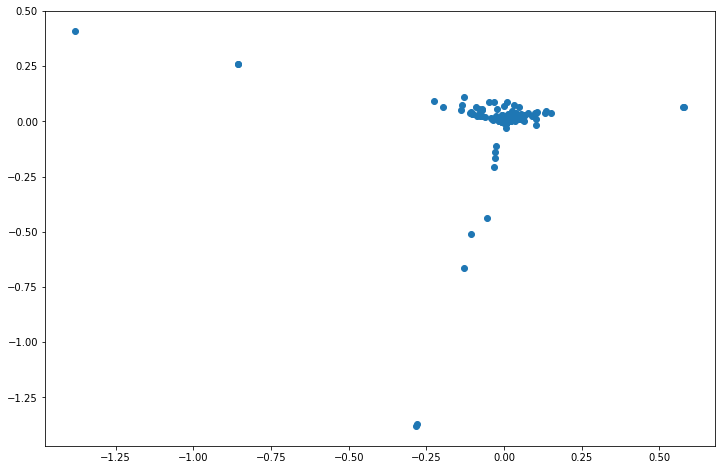

In [157]:
k=20
word_to_vec = embed_graph(distances, k)

plt.figure(figsize=(12,8))
plt.scatter(*embed_graph(distances, 2).transpose())
plt.show()

In [158]:
nlp = spacy.load('en_core_web_lg')

with open('train.txt') as f:
    train = np.array([float(line.strip()) for line in f])

for i, (s1, s2) in enumerate(sentences_test):
    v1 = np.mean(word_to_vec[s1,:], axis=0)
    v2 = np.mean(word_to_vec[s2,:], axis=0)
    d = (cosine_similarity([v1], [v2])[0,0]+1)/2.
    #print(d.shape)
    sent1, sent2 = lines_test[i].split('\t')
    sent1 = nlp(sent1)
    sent1 = nlp(' '.join([str(t) for t in sent1 if not t.is_stop]))
    sent2 = nlp(sent2)
    sent2 = nlp(' '.join([str(t) for t in sent2 if not t.is_stop]))
    #sent1 = nlp(' '.join([word for word in sent1 if word not in english_stopwords]))
    #sent2 = nlp(' '.join([word for word in sent2 if word not in english_stopwords]))
    similarity = sent1.similarity(sent2)
    #if similarity < 0.4:
    print(i, "{:1.8f} {:1.8f} {:1.8f}".format(train[i] / 5, d, similarity), lines_test[i], sep='\t')
    if i > 10:
        break

0	0.48000000 0.96348787 0.92373690	A person is on a baseball team.	A person is playing basketball on a team.
1	0.04000000 0.33965157 0.63757388	Our current vehicles will be in museums when everyone has their own aircraft.	The car needs to some work
2	0.20000000 0.55735866 0.83476240	A woman supervisor is instructing the male workers.	A woman is working as a nurse.
3	0.40000000 0.88529445 0.81605440	A bike is next to a couple women.	A child next to a bike.
4	0.44000000 0.58378775 0.82062957	The group is eating while taking in a breathtaking view.	A group of people take a look at an unusual tree.
5	0.68000000 0.90954946 0.95368330	The boy is raising his hand.	The man is raising his hand.
6	0.16000000 0.82931528 0.81375333	A man with a gray beard is being shaved in front of a lecture hall	A man with a beard is sitting in the grass.
7	0.08000000 0.54155012 0.79174104	The sky has very little to no clouds.	This Lady might be ready for Rock Climbing, or just watching the Clouds, above.
8	0.08

In [159]:
our_simlarity_n = 1-np.array([dist.cosine(np.mean(word_to_vec[s1,:], axis=0), np.mean(word_to_vec[s2,:], axis=0)) for (s1, s2) in sentences_test])/2
spacy_similarity_n = np.array([nlp(' '.join([str(t) for t in nlp(sent2) if not t.is_stop])).similarity(nlp(' '.join([str(t) for t in nlp(sent1) if not t.is_stop]))) for (sent1, sent2) in [s.split('\t') for s in lines_test]])
print(spacy_similarity_n[:10])

print(our_simlarity_n[:10])


[0.9237369  0.63757388 0.8347624  0.8160544  0.82062957 0.9536833
 0.81375333 0.79174104 0.82175876 1.        ]
[0.96348787 0.33965157 0.55735866 0.88529445 0.58378775 0.90954946
 0.82931528 0.54155012 0.45687939 0.9410101 ]


In [79]:
train_n = train/5  
spacy_similarity_scaled = (spacy_similarity_n-0.35)/0.65
print(np.mean(((spacy_similarity_scaled-train_n)**2)))

print(np.mean(((spacy_similarity_n-np.mean(spacy_similarity_n))**2)))
print(np.mean(spacy_similarity_n**2))

0.16965264574028385
0.007678251653702461
0.7751361274991766


In [160]:
train_n = train/5  
spacy_similarity_scaled = (spacy_similarity_n-0.35)/0.65
print(np.mean(((spacy_similarity_scaled-train_n)**2)))

print(np.mean(((spacy_similarity_n-np.mean(spacy_similarity_n))**2)))
print(np.mean(spacy_similarity_n**2))

print('n')
print(np.mean(((our_simlarity_n**4-train_n)**2)))
print(np.mean(((spacy_similarity_n-train_n)**2)))
print(np.mean(((spacy_similarity_n**4-train_n)**2)))
print(np.mean(((spacy_similarity_n-our_simlarity_n)**2)))
t = np.mean(train_n)
print(np.mean(((train_n-t)**2)))

0.16965264574028385
0.007678251653702461
0.7751361274991766
n
0.10003585551639792
0.2299975111999682
0.06236852391124974
0.0389909913319897
0.08105832959999999


In [77]:
 # _n for normalized
print(np.mean(((our_simlarity_n**4-train_n)**2)))
print(np.mean(((spacy_similarity_n-train_n)**2)))
print(np.mean(((spacy_similarity_n**4-train_n)**2)))
print(np.mean(((spacy_similarity_n-our_simlarity_n)**2)))
t = np.mean(train_n)
print(np.mean(((train_n-t)**2)))

0.12356045019689534
0.2299975111999682
0.06236852391124974
0.040218339193988074
0.08105832959999999
